In [36]:
import pytest
from datasets import load_dataset
import torch
import torch.nn as nn
from torch import LongTensor, FloatTensor
from torch.nn import functional as F
from typing import List, Dict, Tuple, Optional
from torch.utils.data import Dataset
from torch.optim import Adam
import time
from tqdm import tqdm

from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [5]:
dataset_base = load_dataset("conll2003")

Downloading:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/650k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/146k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset conll2003 downloaded and prepared to /Users/u14506394/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset_base['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [7]:
import json
mapping_ = {v: k for k, v in dataset_base["train"].features["ner_tags"].feature._str2int.items()}

with open('mapping.json', 'w') as f:
  json.dump(mapping_, f)
mapping_

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

## sklearn crf

In [9]:
pip install sklearn_crfsuite > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import sklearn
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [11]:
df = pd.DataFrame({'sent_id': [i for j in [[i] * len(s['tokens']) for i, s in enumerate(dataset_base['train'])] for i in j],
                   'data': [i for j in dataset_base['train'] for i in j['tokens']],
                   'entities': [mapping_[i] for j in dataset_base['train'] for i in j['ner_tags']]})
df.head(20)

,sent_id,data,entities
0,0,EU,B-ORG
1,0,rejects,O
2,0,German,B-MISC
3,0,call,O
4,0,to,O
5,0,boycott,O
6,0,British,B-MISC
7,0,lamb,O
8,0,.,O
9,1,Peter,B-PER


In [12]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s['data'].values.tolist(), 
                                                     s['entities'].values.tolist())]
        self.grouped = self.data.groupby('sent_id').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None

getter = SentenceGetter(df)
sentences = getter.sentences

In [13]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit()
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper()
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper()
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [14]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [15]:
len(X)

14041

In [16]:
X_train = X[:10000]
X_test = X[10000:]
y_train = y[:10000]
y_test = y[10000:]

In [17]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)
crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|██████████| 10000/10000 [00:01<00:00, 7488.95it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 68239
Seconds required: 0.467

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.17  loss=172342.13 active=68004 feature_norm=1.00
Iter 2   time=0.15  loss=130286.02 active=66816 feature_norm=3.00
Iter 3   time=0.09  loss=109044.75 active=65678 feature_norm=2.57
Iter 4   time=0.16  loss=94855.47 active=66280 feature_norm=2.23
Iter 5   time=0.10  loss=86509.90 active=67032 feature_norm=2.58
Iter 6   time=0.12  loss=76660.45 active=67574 feature_norm=3.25
Iter 7   time=0.11  loss=60714.33 active=67292 feature_norm=5.33
Iter 8   time=0.09  loss=53334.59 active=66153 feature_norm=6.21
Iter 9   time=0.09  loss=47394.52 active=55027 feature_norm=8.14
Iter 10  ti

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

In [18]:
all_entities = sorted(df.entities.unique().tolist())
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=all_entities)

0.9670912566610134

In [19]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=[i for i in all_entities if i != 'O'])

0.8369877440448509

In [44]:
print(metrics.flat_classification_report(y_true = y_test, y_pred = y_pred, labels=[i for i in all_entities if i != 'O']))

              precision    recall  f1-score   support

       B-LOC       0.89      0.86      0.88      2205
      B-MISC       0.91      0.79      0.85      1103
       B-ORG       0.78      0.75      0.77      1739
       B-PER       0.86      0.86      0.86      1976
       I-LOC       0.86      0.69      0.76       422
      I-MISC       0.82      0.62      0.70       370
       I-ORG       0.79      0.80      0.79      1149
       I-PER       0.89      0.95      0.92      1297

   micro avg       0.85      0.82      0.84     10261
   macro avg       0.85      0.79      0.82     10261
weighted avg       0.85      0.82      0.84     10261



## NER

### FCNN

In [46]:
import pytest
from datasets import load_dataset
import torch
import torch.nn as nn
from torch import LongTensor, FloatTensor
from torch.nn import functional as F
from typing import List, Dict, Tuple, Optional, Union
from torch.utils.data import Dataset
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

from collections import Counter

count    14041.000000
mean        14.501887
std         11.602756
min          1.000000
25%          6.000000
50%         10.000000
75%         22.000000
max        113.000000
dtype: float64

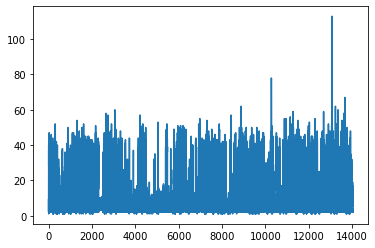

In [47]:
import pandas as pd


max_lens = list()
for row in dataset_base['train']:
    max_lens.append(len(row['tokens']))
max_lens = pd.Series(max_lens)
max_lens.plot();
max_lens.describe()

In [49]:
def get_word_to_idx(count: List[Tuple[str, int]],
                   min_words: Union[int, float] = 0.0,
                   max_words: Union[int, float] = 1.0) -> Dict[str, int]:
    max_count = count[0][1]
    if isinstance(min_words, float):
        min_words = max_count * min_words
    if isinstance(max_words, float):
        max_words = max_count * max_words
        
    all_words = [w[0] for w in count if max_words >= w[1] >= min_words]
    
    all_words = ['<pad>', '<unk>'] + all_words
    
    word_to_idx = {k: v for k, v in zip(all_words, range(0, len(all_words)))}
    return word_to_idx

In [50]:
count = Counter([i for j in dataset_base['train'] for i in j['tokens']])
word_to_idx = get_word_to_idx(count.most_common(), min_words=1)
len(word_to_idx)

23625

In [67]:
def create_matrix_of_texts(dataset, max_sequence_length, 
                           pad_token, word2index):
    texts = np.full((len(dataset), max_sequence_length),
                    word2index[pad_token], dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row['tokens']))
          text = row['tokens'][: trim_length]
          texts[ind, : trim_length] = [word2index[item] for item in text]
    return texts


def create_matrix_of_tags(dataset, max_sequence_length, pad_index):
    tags = np.full((len(dataset), max_sequence_length),
                    pad_index, dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row['ner_tags']))
          labels = row['ner_tags'][: trim_length]
          tags[ind, : trim_length] = [item for item in labels]
    return tags

In [68]:
texts = create_matrix_of_texts(dataset_base['train'], 
                               int(max_lens.quantile(0.97)),
                               '<pad>', word_to_idx)
tags = create_matrix_of_tags(dataset_base['train'],
                             int(max_lens.quantile(0.97)), 0)

In [69]:
class NerDataset(Dataset):
    def __init__(self,
                 texts: np.array,
                 tags: np.array):
        self.tags = tags
        self.texts = texts
        

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens_tensor = torch.tensor(self.texts[idx], dtype=torch.int64)
        return tokens_tensor, torch.tensor(self.tags[idx], dtype=torch.int64)

    def __len__(self) -> int:
        dataset_len = self.texts.shape[0]
        return dataset_len

In [70]:
dataset = dataset_base['train']
ner_dataset = NerDataset(texts, tags)
assert len(ner_dataset) == 14041

In [71]:
' '.join(dataset_base['train'][0]['tokens']), ner_dataset[0]

('EU rejects German call to boycott British lamb .',
 (tensor([  958, 11984,   234,   763,     7,  4148,   210,  6183,     2,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
  tensor([3, 0, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])))

In [72]:
dataset = dataset_base["train"]
ner_dataset = NerDataset(texts, tags)
tokens, labels = ner_dataset[0]
assert isinstance(tokens, LongTensor)
assert isinstance(labels, LongTensor)
assert tokens.shape == labels.shape
tokens, labels = ner_dataset[2]
assert tokens.shape == labels.shape

In [73]:
from torch.utils.data.dataset import random_split

In [74]:
BATCH_SIZE = 32

In [75]:
num_train = int(len(ner_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(ner_dataset, [num_train, len(ner_dataset) - num_train])

train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=False)

In [96]:
class NerModel(nn.Module):
    def __init__(
        self,
        word2idx: Dict,
        embedding_dim: int = 100,
        mapping: Dict[int, str] = None,
        hidden_size: int = 256,
    ):
        super(NerModel, self).__init__()
        if not mapping:
            raise RuntimeError(f'Empty labels')
        self.word2idx = word2idx
        self.labels = mapping
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Embedding(len(self.word2idx), embedding_dim, ),
            nn.Sigmoid(),
            nn.Linear(embedding_dim, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, len(mapping))
        )


    def forward(self, tokens: LongTensor) -> FloatTensor:

        return self.linear_sigmoid_stack(tokens).view(-1, len(self.labels))

In [100]:
model = NerModel(word_to_idx, 100, {idx: str(idx) for idx in range(10)})
assert (
        len(list(name for name, module in model.named_modules())) > 3
    ), "Not enough layers created"

In [101]:
pytorch_total_params = sum(p.numel() for p in model.parameters()
                           if p.requires_grad)

In [102]:
pytorch_total_params

2390926

In [62]:
num_classes = 9
model = NerModel(word_to_idx, 30, {idx: str(idx) for idx in range(num_classes)})
seq_len = 32
example_input = torch.randint(0, 2, (BATCH_SIZE, seq_len), dtype=torch.int64)
logits = model(example_input)
assert isinstance(logits, torch.FloatTensor)
assert logits.shape == (BATCH_SIZE * seq_len, num_classes), f"current size of model output {logits.shape}"

In [63]:
i = iter(train_dataloader)
text, label = next(i)
logits = model(text)
loss_function = nn.CrossEntropyLoss()
loss_function(logits, label.view(-1))

tensor(1.9622, grad_fn=<NllLossBackward>)

### trainig

In [64]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    correct_labels = [value for value in mapping_.values() if value != 'O']
    predicted, true_labels = list(), list()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            tokens, label = batch
            tokens = tokens.to(device)
            
            logits = model(tokens)
            predictions = F.log_softmax(logits, dim=1).reshape(-1,
                                                               40,
                                                               len(mapping_)).argmax(dim=2).flatten().detach().cpu().numpy()
            predicted.extend(predictions)
            true_labels.extend(label.flatten().detach().cpu().numpy())
    
    true_labels = [mapping_[val] for val in true_labels]
    
    predicted = [mapping_[val] for val in predicted]
    print('\n', classification_report(true_labels,
                                      predicted,
                                      labels=correct_labels))

In [65]:
model = NerModel(word_to_idx, 300, mapping_)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

NerModel(
  (linear_sigmoid_stack): Sequential(
    (0): Embedding(23625, 300)
    (1): Sigmoid()
    (2): Linear(in_features=300, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=9, bias=True)
  )
)

In [66]:
for e in range(10):
    total_loss = 0
    model.train()
    loss_function = nn.CrossEntropyLoss()
    for sent in tqdm(train_dataloader):

            # (1) Set gradient to zero for new example: Set gradients to zero before pass
            model.zero_grad()
            
            # (2) Encode sentence and tag sequence as sequences of indices
            input_sent, gold_tags = sent

            # (3) Predict tags (sentence by sentence)
            if len(input_sent) > 0:
                pred_scores = model(input_sent.to(device))
                mask = gold_tags != 0
                # (4) Compute loss and do backward step
                loss = loss_function(pred_scores.to(device), gold_tags.view(-1).to(device))
                loss.backward()
              
                # (5) Optimize parameter values
                optimizer.step()
          
                # (6) Accumulate loss
                total_loss += loss
    print('\nEpoch: %d, loss: %.4f' % (e, total_loss / len(train_dataloader)))
    evaluate(valid_dataloader)

100%|██████████| 416/416 [00:25<00:00, 16.36it/s]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch: 0, loss: 0.2097


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



               precision    recall  f1-score   support

       B-PER       0.00      0.00      0.00       331
       I-PER       0.00      0.00      0.00       273
       B-ORG       0.16      0.15      0.15       346
       I-ORG       0.00      0.00      0.00       211
       B-LOC       0.39      0.91      0.55       380
       I-LOC       0.00      0.00      0.00        59
      B-MISC       0.00      0.00      0.00       147
      I-MISC       0.00      0.00      0.00        49

   micro avg       0.33      0.22      0.26      1796
   macro avg       0.07      0.13      0.09      1796
weighted avg       0.11      0.22      0.14      1796



100%|██████████| 416/416 [00:24<00:00, 16.88it/s]



Epoch: 1, loss: 0.1090


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



               precision    recall  f1-score   support

       B-PER       0.52      0.68      0.59       331
       I-PER       0.23      0.34      0.28       273
       B-ORG       0.61      0.69      0.65       346
       I-ORG       0.54      0.03      0.06       211
       B-LOC       0.90      0.82      0.86       380
       I-LOC       0.00      0.00      0.00        59
      B-MISC       0.87      0.72      0.79       147
      I-MISC       0.00      0.00      0.00        49

   micro avg       0.58      0.55      0.56      1796
   macro avg       0.46      0.41      0.40      1796
weighted avg       0.57      0.55      0.53      1796



100%|██████████| 416/416 [00:26<00:00, 15.45it/s]



Epoch: 2, loss: 0.0710

               precision    recall  f1-score   support

       B-PER       0.54      0.79      0.64       331
       I-PER       0.41      0.38      0.39       273
       B-ORG       0.67      0.70      0.69       346
       I-ORG       0.44      0.51      0.48       211
       B-LOC       0.85      0.86      0.86       380
       I-LOC       0.93      0.22      0.36        59
      B-MISC       0.84      0.80      0.82       147
      I-MISC       0.78      0.29      0.42        49

   micro avg       0.63      0.66      0.64      1796
   macro avg       0.68      0.57      0.58      1796
weighted avg       0.64      0.66      0.64      1796



100%|██████████| 416/416 [00:25<00:00, 16.14it/s]



Epoch: 3, loss: 0.0491

               precision    recall  f1-score   support

       B-PER       0.80      0.67      0.73       331
       I-PER       0.27      0.77      0.40       273
       B-ORG       0.82      0.69      0.75       346
       I-ORG       0.70      0.56      0.62       211
       B-LOC       0.88      0.88      0.88       380
       I-LOC       0.80      0.59      0.68        59
      B-MISC       0.72      0.84      0.78       147
      I-MISC       0.52      0.61      0.56        49

   micro avg       0.61      0.73      0.66      1796
   macro avg       0.69      0.70      0.68      1796
weighted avg       0.71      0.73      0.70      1796



100%|██████████| 416/416 [00:24<00:00, 17.18it/s]



Epoch: 4, loss: 0.0404

               precision    recall  f1-score   support

       B-PER       0.65      0.75      0.70       331
       I-PER       0.29      0.60      0.39       273
       B-ORG       0.82      0.67      0.74       346
       I-ORG       0.81      0.52      0.63       211
       B-LOC       0.86      0.87      0.86       380
       I-LOC       0.71      0.80      0.75        59
      B-MISC       0.72      0.84      0.77       147
      I-MISC       0.21      0.67      0.32        49

   micro avg       0.60      0.72      0.65      1796
   macro avg       0.63      0.71      0.65      1796
weighted avg       0.69      0.72      0.68      1796



100%|██████████| 416/416 [00:25<00:00, 16.58it/s]



Epoch: 5, loss: 0.0372

               precision    recall  f1-score   support

       B-PER       0.53      0.80      0.64       331
       I-PER       0.32      0.51      0.39       273
       B-ORG       0.82      0.72      0.77       346
       I-ORG       0.73      0.60      0.66       211
       B-LOC       0.90      0.84      0.87       380
       I-LOC       0.76      0.86      0.81        59
      B-MISC       0.78      0.86      0.82       147
      I-MISC       0.39      0.61      0.48        49

   micro avg       0.63      0.73      0.68      1796
   macro avg       0.65      0.73      0.68      1796
weighted avg       0.68      0.73      0.69      1796



100%|██████████| 416/416 [00:25<00:00, 16.53it/s]



Epoch: 6, loss: 0.0352

               precision    recall  f1-score   support

       B-PER       0.57      0.78      0.66       331
       I-PER       0.30      0.55      0.39       273
       B-ORG       0.84      0.71      0.77       346
       I-ORG       0.76      0.57      0.65       211
       B-LOC       0.89      0.88      0.89       380
       I-LOC       0.66      0.85      0.74        59
      B-MISC       0.82      0.82      0.82       147
      I-MISC       0.47      0.65      0.55        49

   micro avg       0.64      0.73      0.68      1796
   macro avg       0.67      0.73      0.68      1796
weighted avg       0.69      0.73      0.70      1796



100%|██████████| 416/416 [00:28<00:00, 14.65it/s]



Epoch: 7, loss: 0.0338

               precision    recall  f1-score   support

       B-PER       0.57      0.78      0.66       331
       I-PER       0.43      0.49      0.46       273
       B-ORG       0.77      0.74      0.76       346
       I-ORG       0.33      0.68      0.44       211
       B-LOC       0.95      0.77      0.85       380
       I-LOC       0.86      0.61      0.71        59
      B-MISC       0.87      0.74      0.80       147
      I-MISC       0.46      0.65      0.54        49

   micro avg       0.61      0.70      0.65      1796
   macro avg       0.65      0.69      0.65      1796
weighted avg       0.67      0.70      0.67      1796



100%|██████████| 416/416 [00:25<00:00, 16.02it/s]



Epoch: 8, loss: 0.0324

               precision    recall  f1-score   support

       B-PER       0.66      0.76      0.71       331
       I-PER       0.31      0.56      0.40       273
       B-ORG       0.91      0.60      0.72       346
       I-ORG       0.59      0.57      0.58       211
       B-LOC       0.79      0.93      0.85       380
       I-LOC       0.66      0.81      0.73        59
      B-MISC       0.83      0.84      0.84       147
      I-MISC       0.60      0.65      0.63        49

   micro avg       0.64      0.72      0.67      1796
   macro avg       0.67      0.72      0.68      1796
weighted avg       0.69      0.72      0.69      1796



100%|██████████| 416/416 [00:27<00:00, 14.88it/s]



Epoch: 9, loss: 0.0317

               precision    recall  f1-score   support

       B-PER       0.65      0.73      0.69       331
       I-PER       0.28      0.62      0.38       273
       B-ORG       0.84      0.66      0.74       346
       I-ORG       0.68      0.50      0.57       211
       B-LOC       0.81      0.92      0.86       380
       I-LOC       0.33      0.88      0.48        59
      B-MISC       0.84      0.80      0.82       147
      I-MISC       0.50      0.69      0.58        49

   micro avg       0.59      0.72      0.65      1796
   macro avg       0.62      0.72      0.64      1796
weighted avg       0.67      0.72      0.68      1796

